In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
df= pd.read_csv('final.csv')
df

,District,"weighted avg population ( prevalence of symptoms of acute respiratory infection (ari) in the 2 weeks preceding the survey (%) )-Calendar Year (Jan - Dec), 2019","weighted avg population ( prevalence of diarrhoea in the 2 weeks preceding the survey (%) )-Calendar Year (Jan - Dec), 2019",Coordinates,Nearest Mine Coord,Distance to Mine (km),NDVI_Loss_Percent
0,adilabad,1.7,10.3,"(19.6759452, 78.5339895)","(19.0908141, 78.3638702)",67.192139,9.0
1,agar-malwa,NaN,0.8,"(23.935092, 76.1449595)","(25.8307441, 75.2647537)",228.040373,4.4
2,agra,4.5,6.8,"(27.1752554, 78.0098161)","(27.1059398, 76.2453629)",175.079372,4.1
3,ahmadabad,1.0,1.8,"(23.0215374, 72.5800568)","(24.3393891, 73.6949801)",185.028512,6.3
4,ahmednagar,2.7,15.9,"(19.1627725, 74.8580243)","(19.0908141, 78.3638702)",368.936848,2.1
...,...,...,...,...,...,...,...
696,yadgir,0.6,5.1,"(16.5744123, 76.9254434)","(16.1984854, 76.6507147)",50.911348,7.9
697,yamunanagar,6.6,7.2,"(30.1231349, 77.286329)","(29.1465403, 79.4769342)",238.149843,4.8
698,yanam,NaN,2.5,"(16.7332235, 82.2018118)","(17.4603889, 80.6579563)",182.961323,4.6
699,yavatmal,NaN,7.4,"(20.0638677, 78.3565663)","(19.0908141, 78.3638702)",107.718865,7.1


In [85]:
df= pd.read_csv('final.csv')

#columns to latitude and longitutde
import ast

df['Latitude'] = df['Coordinates'].apply(lambda x: ast.literal_eval(x)[0] if pd.notnull(x) else None)
df['Longitude'] = df['Coordinates'].apply(lambda x: ast.literal_eval(x)[1] if pd.notnull(x) else None)


#dropping of unnecessary columns
df.drop(columns=['Coordinates','Nearest Mine Coord'],inplace=True )

#renaming columns for clarity
df.rename(columns={df.columns[1]:'respiratory_problem',df.columns[2]:'diarrohea'},inplace=True)

#distance to inverse distance because we want to give more weight to closer mines
df['inverse_distance'] = 1 / (1 + df['Distance to Mine (km)'])



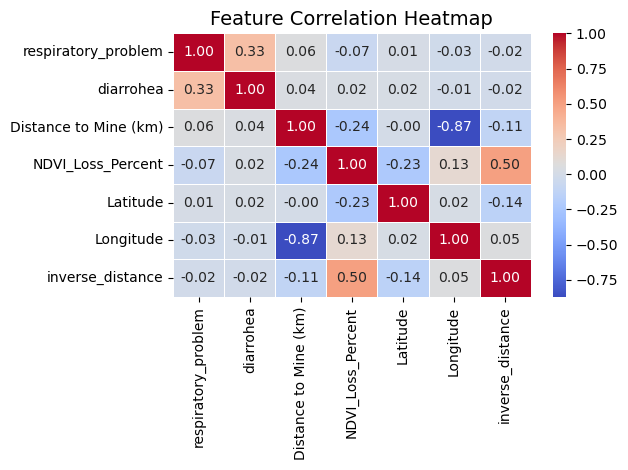

In [87]:
#feature correlation heatmap

sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()


In [89]:

#features 
features= ['respiratory_problem','diarrohea','inverse_distance','NDVI_Loss_Percent']

#converting features to numeric 
df[features]= df[features].apply(pd.to_numeric,errors='coerce')

#normalisation and risk calculation
normalized = (df[features] - df[features].min()) / (df[features].max() - df[features].min())
df["risk"] = normalized.mean(axis=1)

# Assigning high risk based on a threshold
threshold=df['risk'].quantile(0.70)
df['high_risk']=(df['risk']>threshold).astype(int)

# Splitting the dataset into features and target variable
target = df['high_risk']
X=pd.DataFrame(df[features],columns=features)

# Handling missing values by filling with mean
X=X.fillna(X.mean())

df = pd.concat([df['Latitude'],df['Longitude'],df['respiratory_problem'], df['diarrohea'],df['risk'],df['Distance to Mine (km)'],df['NDVI_Loss_Percent'],df['high_risk'],df['inverse_distance']], axis=1)






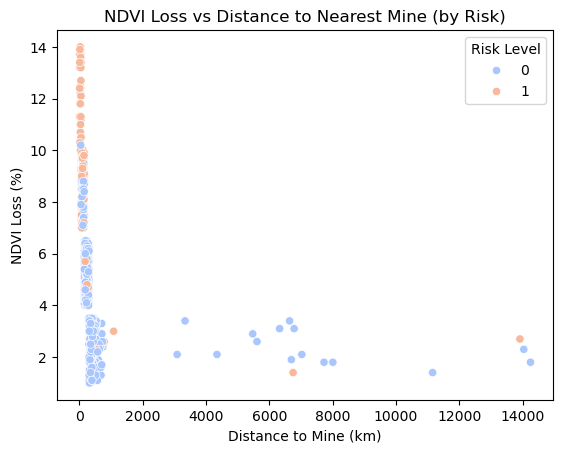

In [91]:
#scatterplot

sns.scatterplot(
    data=df,
    x='Distance to Mine (km)',
    y='NDVI_Loss_Percent',
    hue='high_risk',
    palette='coolwarm'
)
plt.title("NDVI Loss vs Distance to Nearest Mine (by Risk)")
plt.xlabel("Distance to Mine (km)")
plt.ylabel("NDVI Loss (%)")
plt.legend(title='Risk Level')
plt.show()


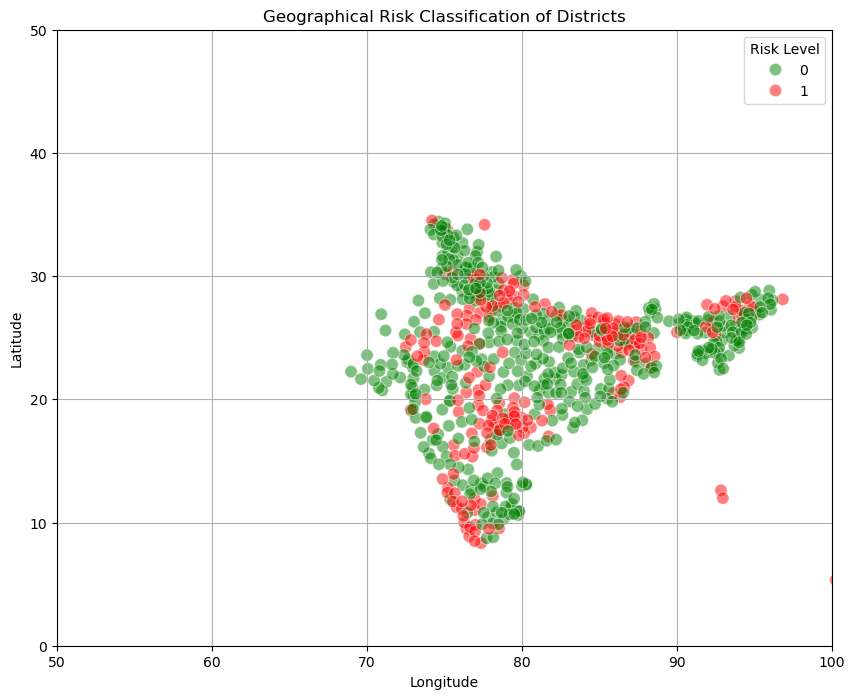

In [101]:
geo_risk_df = df.dropna(subset=['Latitude', 'Longitude', 'high_risk'])
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=geo_risk_df,
    x='Longitude',
    y='Latitude',
    hue='high_risk',
    palette={0: 'green', 1: 'red'},
    s=80,
    alpha=0.5
)
# Set latitude and longitude range
plt.xlim(50, 100)       # Longitude range
plt.ylim(0, 50)       # Latitude range

plt.title("Geographical Risk Classification of Districts")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend(title='Risk Level')
plt.show()

In [64]:


# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=42)

# Scaling the features using StandardScaler
scaler = StandardScaler()
X_trainscaled = scaler.fit_transform(X_train)
X_testscaled=scaler.transform(X_test)

# Converting scaled arrays back to DataFrame for consistency
X_trainscaled = pd.DataFrame(X_trainscaled,columns=features)
X_testscaled = pd.DataFrame(X_testscaled,columns=features)

# Training the Random Forest Classifier
clf=RandomForestClassifier(n_estimators= 400 ,max_depth=3,random_state=42)
clf.fit(X_trainscaled,y_train)

# Making predictions on the test set
y_pred = clf.predict(X_testscaled)

# Evaluating the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))




Confusion Matrix:
[[145   0]
 [ 12  54]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       145
           1       1.00      0.82      0.90        66

    accuracy                           0.94       211
   macro avg       0.96      0.91      0.93       211
weighted avg       0.95      0.94      0.94       211

